In [24]:
# 1. Imports et configuration
# ===============================
print("Étape 1 : Chargement des bibliothèques")

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("Bibliothèques chargées\n")


Étape 1 : Chargement des bibliothèques
Bibliothèques chargées



In [25]:

# 2. Chargement des données

print("Étape 2 : Chargement du dataset")

data = pd.read_csv("bdd/train.csv")
print(f"Nombre de passagers : {data.shape[0]}")
print(f"Nombre de variables : {data.shape[1]}")
print(f"Taux de survie global : {data['Survived'].mean():.2%}")
data.head()


Étape 2 : Chargement du dataset
Nombre de passagers : 891
Nombre de variables : 12
Taux de survie global : 38.38%


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Étape 3 : Analyse des valeurs manquantes

<!-- Analyse des valeurs manquantes
Tu comptes combien de valeurs sont manquantes par colonne, et tu affiches celles qui en ont au moins une.
Cela permet d’identifier où il faut faire un nettoyage ou une imputation. -->

In [26]:
# ===============================
# 3. Analyse des valeurs manquantes
# ===============================
print("Étape 3 : Analyse des valeurs manquantes")

missing = data.isnull().sum()
missing = missing[missing > 0]
print(missing)

# Visualisation interactive des valeurs manquantes
import plotly.express as px

fig_missing = px.bar(missing.sort_values(),
                     title="Valeurs manquantes par variable",
                     labels={"value": "Nombre de valeurs manquantes", "index": "Variables"})
fig_missing.update_layout(xaxis_title="Variables", yaxis_title="Valeurs manquantes")
fig_missing.show()


Étape 3 : Analyse des valeurs manquantes
Age         177
Cabin       687
Embarked      2
dtype: int64


#  Étape 4 : Feature

<!-- Je  crées de nouvelles variables pour enrichir le jeu de données et aider la modélisation :

Family : taille de la famille (SibSp + Parch + 1).

FamilySize : catégorisation de la taille (Solo, Small, Large).

Title : extraction du titre (Mr, Mrs, Miss, etc.) depuis la colonne Name.

Tu regroupes les titres rares en une seule catégorie "Rare".

Age_bin : découpage de l’âge en classes d’âge.

Fare_bin : découpage du tarif en quartiles.

IsAlone : variable binaire indiquant si la personne est seule ou pas. -->

In [27]:

# 4. Feature

print("Étape 4 : Création de nouvelles variables")

# Taille de la famille
data["Family"] = data["SibSp"] + data["Parch"] + 1

# Taille de famille catégorisée
data["FamilySize"] = data["Family"].apply(lambda x: 'Solo' if x == 1 else 'Small' if x <= 4 else 'Large')

# Extraction du titre
def get_title(name):
    return name.split(",")[1].split(".")[0].strip()

data["Title"] = data["Name"].apply(get_title)

# Regroupement des titres rares
rare_titles = data["Title"].value_counts()[data["Title"].value_counts() < 5].index.tolist()
data["Title"] = data["Title"].replace(rare_titles, "Rare")

#  âge et tarif
data["Age_bin"] = pd.cut(data["Age"], bins=[0, 12, 20, 40, 60, 80],
                         labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

data["Fare_bin"] = pd.qcut(data["Fare"], q=4, labels=['Low', 'Medium', 'High', 'Very_High'])

# Est seul ?
data["IsAlone"] = (data["Family"] == 1).astype(int)

print("Nouvelles variables créées")




Étape 4 : Création de nouvelles variables
Nouvelles variables créées


In [28]:
# Répartition des tailles de famille selon la survie
fig_fam = px.histogram(data, x="FamilySize", color="Survived",
                       barmode="group", title="Répartition des tailles de famille selon la survie",
                       category_orders={"FamilySize": ["Solo", "Small", "Large"]})
fig_fam.show()

# Répartition des titres selon la survie
fig_title = px.histogram(data, x="Title", color="Survived",
                         barmode="group", title="Titres des passagers selon la survie")
fig_title.show()


#  Étape 5 : Imputation des données manquantes

<!-- on complète les valeurs manquantes dans la colonne Age en remplaçant les valeurs manquantes par la médiane d’âge regroupée par titre et classe (Pclass).
Pour la colonne Embarked (port d’embarquement), tu remplaces les valeurs manquantes par la modalité la plus fréquente. -->

In [ ]:
print("Étape 5 : Imputation des valeurs manquantes")

# Imputation de l'âge selon le groupe Title + Pclass
if all(col in data.columns for col in ['Age', 'Title', 'Pclass']):
    data['Age'] = data.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

# Imputation de 'Embarked' (mode du jeu principal)
if 'Embarked' in data.columns:
    mode_embarked = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].fillna(mode_embarked)

if 'Embarked' in test_data.columns:
    test_data['Embarked'] = test_data['Embarked'].fillna(mode_embarked if 'mode_embarked' in locals() else 'S')

print(" Imputations terminées.")


Étape 5 : Imputation des valeurs manquantes


NameError: name 'test_data' is not defined

# Preprocessing

<!-- On crée une nouvelle colonne Title extraite de Name.

On remplace les valeurs manquantes dans Age en utilisant la médiane par groupe (Title, Pclass).

On remplace les valeurs manquantes dans Embarked par la valeur la plus fréquente.

On applique ces remplacements dans les deux datasets data et test_data. -->

In [ ]:

import pandas as pd

def preprocess(data, test_data=None):
    print("=== Étape 5 : Imputation des valeurs manquantes ===")

    # Imputation de l'âge par médiane selon le groupe Title + Pclass
    if all(col in data.columns for col in ['Age', 'Title', 'Pclass']):
        data['Age'] = data.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

    # Imputation de 'Embarked' dans data
    mode_embarked = data['Embarked'].mode()[0] if 'Embarked' in data.columns else 'S'
    if 'Embarked' in data.columns:
        data['Embarked'] = data['Embarked'].fillna(mode_embarked)

    # Appliquer les mêmes imputations à test_data si fourni
    if test_data is not None:
        if 'Embarked' in test_data.columns:
            test_data['Embarked'] = test_data['Embarked'].fillna(mode_embarked)
        else:
            test_data['Embarked'] = mode_embarked

        if all(col in test_data.columns for col in ['Age', 'Title', 'Pclass']):
            age_medians = data.groupby(['Title', 'Pclass'])['Age'].median()
            test_data['Age'] = test_data.apply(
                lambda row: age_medians.get((row['Title'], row['Pclass']), data['Age'].median())
                if pd.isnull(row['Age']) else row['Age'], axis=1
            )

    print(" Valeurs manquantes traitées.\n")
    return data, test_data


#  Étape 6 : Nettoyage, encodage et split train/test

<!-- On supprime les colonnes non pertinentes ou trop complexes à exploiter (Name, Ticket, Cabin, PassengerId).
on transforme les variables catégorielles en variables indicatrices (one-hot encoding) pour que les modèles puissent les comprendre.
on sépare les données en variables explicatives X et variable cible y. -->

In [ ]:
# 6. Préparation finale des données

print("Étape 6 : Nettoyage et encodage des données")

# Suppression de colonnes non pertinentes pour le modèle (seulement si elles existent)
cols_to_drop = ["Name", "Ticket", "Cabin", "PassengerId"]
data = data.drop(columns=[col for col in cols_to_drop if col in data.columns])

# Encodage one-hot des variables catégorielles (seulement si elles existent)
cat_vars = ["Sex", "Embarked", "Title", "FamilySize", "Age_bin", "Fare_bin"]
cat_vars = [col for col in cat_vars if col in data.columns]
data = pd.get_dummies(data, columns=cat_vars, drop_first=True)

# Définition des variables d'entrée et de la cible
X = data.drop("Survived", axis=1)
y = data["Survived"]

# Séparation en jeu d'entraînement et jeu de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dimensions X_train : {X_train.shape}")
print(f"Dimensions X_test  : {X_test.shape}")


Étape 6 : Nettoyage et encodage des données
Dimensions X_train : (712, 25)
Dimensions X_test  : (179, 25)


#       Étape 7 : Standardisation
<!-- mettre tout modèles (SVM, régression logistique) et mettre les variables sur la même échelle.
on standardise donc les données d’entraînement puis les appliques la même transformation au jeu de test. -->

In [ ]:

# 7. Standardisation

print("Étape 7 : Standardisation")

scaler = StandardScaler()

#Ajustement sur les données d'entraînement et transformation
X_train_scaled = scaler.fit_transform(X_train)

# Transformation des données de test
X_test_scaled = scaler.transform(X_test)

print("Standardisation terminée")


Étape 7 : Standardisation
Standardisation terminée


#  Étape 8 : Entraînement des modèles de base
<!-- on entraîne trois modèles classiques :

Random Forest (non standardisé car les arbres ne sont pas sensibles à l’échelle),

Régression Logistique et SVM (Standardisés).

Pour chacun, on évalue la performance moyenne avec une validation croisée (5 folds) sur le jeu d’entraînement.
Entraînement et test : Pour chaque itération, un pli est utilisé comme ensemble de test, tandis que les 4 autres plis sont utilisés pour entraîner le modèle. 
-->

In [ ]:

# 8.    # Modélisation de base
 #teste plusieurs algorithmes sur les données d'entraînement en évaluant leurs performances par validation croisée.

print("Étape 8 : Entraînement des modèles")

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42)
}

model_scores = {}
from sklearn.model_selection import cross_val_score

#Boucle d’entraînement et d’évaluation avec validation croisée :
for name, model in models.items():
    print(f"Test du modèle : {name}")
    if name == "Random Forest":
        scores = cross_val_score(model, X_train, y_train, cv=5)
    else:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5) #Pour Logistic Regression et SVM, on utilise les données standardisées (X_train_scaled) car ces modèles sont sensibles
    model_scores[name] = scores.mean()
    print(f"Score moyen : {scores.mean():.4f}")

best_model_name = max(model_scores, key=model_scores.get)
print(f"Meilleur modèle sélectionné : {best_model_name}")


Étape 8 : Entraînement des modèles
Test du modèle : Random Forest
Score moyen : 0.8020
Test du modèle : Logistic Regression
Score moyen : 0.8147
Test du modèle : SVM
Score moyen : 0.8216
Meilleur modèle sélectionné : SVM


#        Étape 9 : Optimisation GridSearchCV

<!-- GridSearchCV pour chercher les meilleurs hyperparamètres 
Par exemple nombre d’arbres, profondeur max pour Random Forest,

Régularisation pour la régression logistique,

Paramètres C et kernel pour le SVM.
GridSearchCV fait une validation croisée interne pour trouver la meilleure combinaison.

-->

In [ ]:

print("Étape 9 : Optimisation GridSearch")

from sklearn.model_selection import GridSearchCV

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200], #Nombre d'arbres de décision dans la forêt
        'max_depth': [None, 10], # Profondeur maximale des arbres
        'min_samples_split': [2, 5] # Nombre minimum d'échantillons requis pour diviser un nœud interne
    }
    grid = GridSearchCV(models[best_model_name], param_grid, cv=5, n_jobs=-1)  # cv=5 signifie que chaque combinaison est testée via une validation croisée 5 fois pour avoir une moyenne fiable.
    grid.fit(X_train, y_train)

elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10], # Inverse de la force de régularisation
        'penalty': ['l2'], # Type de pénalité
        'solver': ['lbfgs'] # Algorithme d'optimisation
    }
    grid = GridSearchCV(models[best_model_name], param_grid, cv=5, n_jobs=-1) 
    grid.fit(X_train_scaled, y_train)

else:  # SVM
    param_grid = {
        'C': [0.1, 1],
        'kernel': ['rbf'],
        'gamma': ['scale']
    }
    grid = GridSearchCV(models[best_model_name], param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)

optimized_model = grid.best_estimator_
print("Meilleurs paramètres :", grid.best_params_)


Étape 9 : Optimisation GridSearch
Meilleurs paramètres : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


#       10. Évaluation finale
<!--  calcules la courbe ROC (taux de faux positifs en fonction du taux de vrais positifs) 

Target (y) = Survived :

0 = Le passager n’a pas survécu 

1 = Le passager a survécu

98 passagers non survivants bien classés (TN) True negative

12 passagers non survivants prédit survivants (FP) fake potitive

18 passagers survivants prédit non survivants (FN)

51 passagers survivants bien classés (TP) True positive 

Vrai positif () - Il s’agit des prédictions correctes faites qui sont étiquetées comme positives. Vous pouvez saisir cette valeur et les valeurs ci-dessous dans la première section du calculateur de matrice de confusion.TP
Faux négatif () - Il s’agit des mauvaises prédictions faites qui sont étiquetées comme négatives.FN
Faux positif () - Il s’agit des mauvaises prédictions faites qui sont étiquetées comme positives.FP
Vrai négatif () - Il s’agit des prédictions correctes faites qui sont étiquetées comme négatives.TN
-->

Étape 10 : Évaluation finale
Accuracy : 0.8324022346368715
Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Matrice de confusion :
 [[98 12]
 [18 51]]


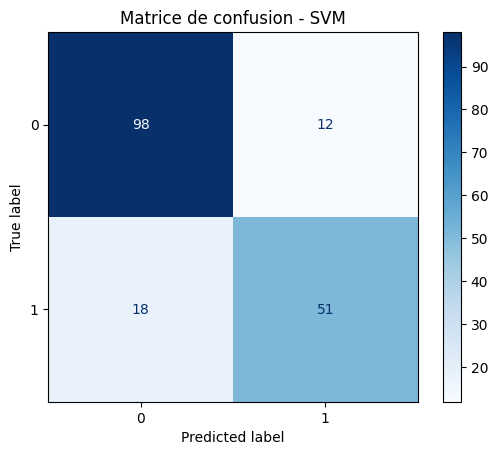

In [ ]:

print("Étape 10 : Évaluation finale")

if best_model_name == 'Random Forest':
    y_pred = optimized_model.predict(X_test)
    y_proba = optimized_model.predict_proba(X_test)[:, 1]
else:
    y_pred = optimized_model.predict(X_test_scaled) #les prédictions binaires (0 ou 1)
    y_proba = optimized_model.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Rapport de classification :\n", classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt



# Affichage matrice de confusion avec matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=optimized_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matrice de confusion - {best_model_name}')
plt.show()



#  11. Courbe ROC
<!-- La courbe ROC est un outil graphique utilisé pour évaluer la performance d’un modèle de classification binaire-->

In [ ]:

print("Étape 11 : Courbe ROC")

from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

fpr, tpr, _ = roc_curve(y_test, y_proba) #calcule les taux de faux positifs et vrais positifs pour différents seuils.
roc_auc = auc(fpr, tpr)  #calcule l’aire sous la courbe ROC obtenue.
print(f"AUC ROC : {roc_auc:.4f}")

# Visualisation avec Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr,
                         mode='lines',
                         name=f'ROC curve (AUC = {roc_auc:.2f})',
                         line=dict(color='darkorange', width=3)))

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                         mode='lines',
                         name='Random Classifier',
                         line=dict(color='navy', width=2, dash='dash')))

fig.update_layout(title='Courbe ROC',
                  xaxis_title='Taux de faux positifs (FPR)',
                  yaxis_title='Taux de vrais positifs (TPR)',
                  legend=dict(x=0.6, y=0.1),
                  template='plotly_white')

fig.show()


Étape 11 : Courbe ROC
AUC ROC : 0.8466


# visualiser la courbe ROC avec plotly

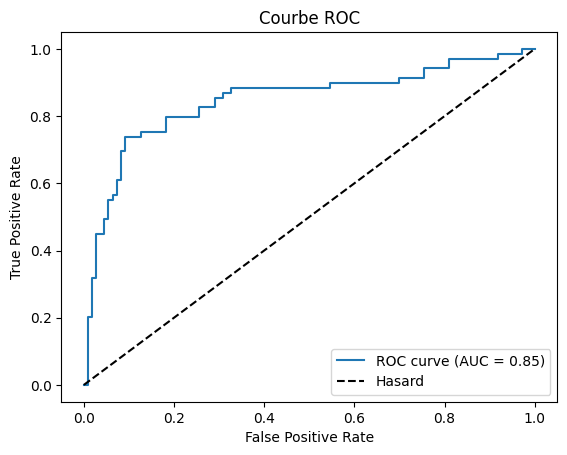

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Hasard')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


# submission

In [ ]:
# 1. Chargement des données
train = pd.read_csv('bdd/train.csv')
test = pd.read_csv('bdd/test.csv')

# 2. Imputation des valeurs manquantes

# Remplissage Age avec la médiane
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(train['Age'].median(), inplace=True)

# Remplissage Embarked avec la valeur la plus fréquente dans train
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# 3. Encodage des variables catégorielles

# Sex → 0/1
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

# Embarked → one-hot encoding
train = pd.concat([train, pd.get_dummies(train['Embarked'], prefix='Embarked')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Embarked'], prefix='Embarked')], axis=1)

train.drop('Embarked', axis=1, inplace=True)
test.drop('Embarked', axis=1, inplace=True)

# 4. Sélection des features pour le modèle
features = ['Pclass', 'Age', 'Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

# 5. Entraînement du modèle
model = RandomForestClassifier(random_state=42)
model.fit(train[features], train['Survived'])

# 6. Prédictions sur test
predictions = model.predict(test[features])

# 7. Création du fichier submission
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': predictions
})

submission.to_csv('submission.csv', index=False)

print("Fichier submission.csv créé avec succès !")


Fichier submission.csv créé avec succès !
